In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generate Dataframe
df = pd.read_csv("uber-fares-dataset/uber.csv")

## Cleaning the Data

Before we start formally cleaning the data, we made sure to take a look at the data we are working with as well as their data types and potential missing values.

Right off the bat, we noted that some latitude and longitude values do not fall within the actual latitude and longitude ranges.
For example, latitude values range between -90 and 90 whereas longitude values range between -180 and 180. Values like -3356.66630 for the longitude will skew the data, so we will need to handle their observational units accordingly.

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


From the .info() function we found that the longitude and latitude values contain a null value. We will need to address that later during our data cleanup.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


We decided to plot fare_amount vs passenger count to see if we could find any correlations for data evaluation, and we found that the passenger count contains an outlier, which we will also need to address during the data cleanup.

<AxesSubplot:xlabel='fare_amount', ylabel='passenger_count'>

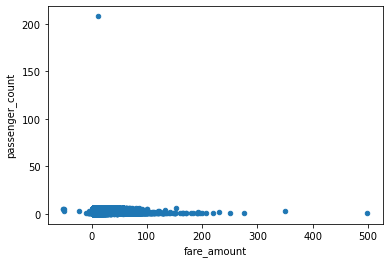

In [6]:
df.plot(kind="scatter", x="fare_amount", y="passenger_count")

To combat the rather strange values in the latitude and longitude columns, we will need to remove any observational units that do not fall within the specified latitude and longitude range. 

Before doing so, we will first need to drop any null values from our dataset.

In [7]:
df = df.dropna()

In [8]:
# Drop Pickup Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['pickup_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['pickup_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['pickup_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['pickup_longitude'] < -180].index, inplace=True)


In [9]:
# Drop Dropoff Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['dropoff_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['dropoff_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['dropoff_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['dropoff_longitude'] < -180].index, inplace=True)


In [10]:
# Drop the outlier in the passenger_count
df.drop(df.loc[df['passenger_count'] > 200].index, inplace=True)
df.drop(df.loc[df['passenger_count'] <= 0].index, inplace=True)

Because a lot of Uber fares are related to the distance traveled and demand (but demand cannot be calculated in this context), we will calculate the distance traveled for each Uber ride and create a variable containing the distance traveled. Hopefully, from this calculation we can see an accurate reflection of the correlation between the variables.

In [11]:
# Convert the latitude and longitude values to radians for calculation purposes
np.radians(df['pickup_latitude'])
np.radians(df['pickup_longitude'])

np.radians(df['dropoff_latitude'])
np.radians(df['dropoff_longitude'])

0        -1.291535
1        -1.291451
2        -1.290890
3        -1.290938
4        -1.291074
            ...   
199995   -1.291308
199996   -1.291660
199997   -1.289082
199998   -1.291251
199999   -1.291291
Name: dropoff_longitude, Length: 199278, dtype: float64

In [12]:
# Calculation Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth. 
# Distance, d = 3963.0 * arccos[(sin(lat1) * sin(lat2)) + cos(lat1) * cos(lat2) * cos(long2 – long1)]

df['distance_traveled'] = 3963.0 * np.arccos(((np.sin(df['pickup_latitude']) * np.sin(df['dropoff_latitude'])) + np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) * np.cos(df['dropoff_longitude']-df['pickup_longitude'])))

In [13]:
# Converting the date & time variable to an actual date & time Dtype
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [14]:
# Creating day and hour variables using pickup_datetime, will use to calculate effect of timing/date on fare

df['day'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

In [15]:
# Drop any values = to infinity

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

From taking a look at .info() and .describe, we can see that there are no longer any null/inf values and all the latitude and longitude values fall within normal ranges. Now we can start with our preprocessing.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199165 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   Unnamed: 0         199165 non-null  int64              
 1   key                199165 non-null  object             
 2   fare_amount        199165 non-null  float64            
 3   pickup_datetime    199165 non-null  datetime64[ns, UTC]
 4   pickup_longitude   199165 non-null  float64            
 5   pickup_latitude    199165 non-null  float64            
 6   dropoff_longitude  199165 non-null  float64            
 7   dropoff_latitude   199165 non-null  float64            
 8   passenger_count    199165 non-null  int64              
 9   distance_traveled  199165 non-null  float64            
 10  day                199165 non-null  int64              
 11  hour               199165 non-null  int64              
dtypes: datetime64[ns, UTC](1), flo

In [17]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_traveled,day,hour
count,1.991650e+05,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000,199165.000000
mean,2.771724e+07,11.367451,-72.503134,39.918590,-72.512632,39.922496,1.689489,147.604705,3.049381,13.492742
std,1.601431e+07,9.909977,10.445844,6.129783,10.409178,6.117640,1.305390,360.789741,1.946611,6.516453
min,1.000000e+00,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000,0.000000,0.000000,0.000000
25%,1.382813e+07,6.000000,-73.992062,40.734798,-73.991407,40.733829,1.000000,49.210683,1.000000,9.000000
50%,2.775737e+07,8.500000,-73.981826,40.752585,-73.980095,40.753042,1.000000,85.046336,3.000000,14.000000
75%,4.156231e+07,12.500000,-73.967170,40.767155,-73.963670,40.767995,2.000000,151.705649,5.000000,19.000000
max,5.542357e+07,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000,12056.697494,6.000000,23.000000


## Using OneHotEncoder & Scaling, Normalizing, and Standardizing Features using sklearn.preprocessing

Before we jump into anything else, we decided on preprocessing the data in order to standardize the dataset. This will make the rest of the process run smoother because the data will "change raw feature vectors into a representation that is more suitable for the downstream estimators." (Source: https://scikit-learn.org/stable/modules/preprocessing.html)

In [18]:
# Drop the key, unname, pickup_datetime, long & lat variables (extracted the necessary information from these variables/their variable types interfere with the scaler)
df_scale = df.drop({"key", 'pickup_datetime', 'Unnamed: 0', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'}, axis = 1)
df_scale.drop_duplicates(inplace=True)
df_scale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198461 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        198461 non-null  float64
 1   passenger_count    198461 non-null  int64  
 2   distance_traveled  198461 non-null  float64
 3   day                198461 non-null  int64  
 4   hour               198461 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 9.1 MB


In [19]:
# Referenced Textbook for OneHotEncoder 
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_scale[{'passenger_count', 'day', 'hour'}])
df_cat_1hot

<198461x37 sparse matrix of type '<class 'numpy.float64'>'
	with 595383 stored elements in Compressed Sparse Row format>

In [20]:
df_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [21]:
cat_encoder.categories_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([1, 2, 3, 4, 5, 6]),
 array([0, 1, 2, 3, 4, 5, 6])]

Before running the scaler on the data, we will need to drop any categorical variables/any variables that are not in a number format because the scaler only works with number data.

Then, we will run the StandardScaler on the dataframe and check the mean and scale.

In [22]:
scaler = preprocessing.StandardScaler().fit(df_scale)

In [23]:
scaler.mean_

array([ 11.38212334,   1.69151622, 148.12830242,   3.04979316,
        13.49024242])

In [24]:
scaler.scale_

array([  9.92021105,   1.30687509, 361.3208697 ,   1.94681392,
         6.5184062 ])

Next, we will transform the scaler and store it in a new dataframe and also check the mean and standard deviation.

In [25]:
df_scaled = scaler.transform(df_scale)
df_scaled.mean(axis=0)

array([1.48043908e-16, 4.50039161e-17, 4.85125746e-17, 4.07255008e-18,
       1.29659254e-16])

In [26]:
df_scaled.std(axis=0)

array([1., 1., 1., 1., 1.])

After scaling the data, we created a correlation matrix to see how the rest of the data relates to the fare amount. From looking at the correlation matrix, we found that none of the columns have a strong correlation to the fare amount.

In [27]:
corr_matrix = df_scale.corr()

In [28]:
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
distance_traveled    0.367400
passenger_count      0.009279
day                  0.007285
hour                -0.021531
Name: fare_amount, dtype: float64

## Use sklearn.linear_model.LinearRegression & Use k-fold Cross Validation (cross_val_score)

In [29]:
# Using Linear Regression

lin_reg = LinearRegression()
df_prepared = df_scale[{'distance_traveled', 'passenger_count', 'hour'}]
df_label = df_scale['fare_amount']
lin_reg.fit(df_prepared, df_label)

LinearRegression()

In [30]:
# Cross Validation Score
print(cross_val_score(lin_reg, df_prepared, df_label, cv=10))

[0.13071501 0.14349203 0.14085825 0.14825432 0.1344076  0.13115354
 0.12506605 0.11685031 0.12910944 0.14973383]


In [31]:
some_data = df_prepared.iloc[:5]
some_labels = df_label.iloc[:5]

print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))


Predictions: [10.30407136 10.5559907  11.76358214 10.77815219 12.04353389]
Labels: [7.5, 7.7, 12.9, 5.3, 16.0]


## Use sklearn.metrics.mean_squared_error and at least one other sklearn.metrics option to evaluate model performance 

The other metric we decided on was the Mean Absolute Error.

In [32]:
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_label, df_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE: ", lin_rmse)

Linear Regression RMSE:  9.224465392507582


In [33]:
lin_mae = mean_absolute_error(df_label, df_predictions)
print("Linear Regression MAE: ", lin_mae)

Linear Regression MAE:  5.288341081176825


In [34]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [35]:
lin_scores = cross_val_score(lin_reg, df_prepared, df_label,
                             scoring="neg_mean_squared_error", cv=10)
display_scores(lin_scores)

Scores: [-91.49473315 -82.96006359 -87.76933854 -77.34559084 -83.16356006
 -82.38960929 -81.942271   -83.58689502 -91.63895434 -88.87074333]
Mean: -85.1161759157182
Standard deviation: 4.393844998241902


## Use sklearn.tree.DecisionTreeRegressor

In [36]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_label)
df_predictions = tree_reg.predict(df_prepared)

In [37]:
tree_mse = mean_squared_error(df_label, df_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree Regression RMSE: ", tree_rmse)

Decision Tree Regression RMSE:  2.2668958199289997


In [38]:
# The other scikit metric = mean absolute error
tree_mae = mean_absolute_error(df_label, df_predictions)
print("Decision Tree Regression MAE: ", tree_mae)

Decision Tree Regression MAE:  0.18509039685071452


In [39]:
scores = cross_val_score(tree_reg, df_prepared, df_label,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [40]:
display_scores(tree_rmse_scores)

Scores: [8.20042826 6.92705457 6.98283789 6.62235055 6.37500503 6.24477948
 6.94378095 6.796408   7.20147958 7.09445489]
Mean: 6.938857920862906
Standard deviation: 0.510586126814283


## Use Ordinal Encoder and KNN regressor, Combine into Single Pipeline

In [41]:
# Define rows
numerical_attributes = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'distance_traveled']
ordinal_attributes = ['passenger_count', 'hour']

train_set, test_set = train_test_split(df, test_size=0.2, random_state=1)

# Define transformer
transform = ColumnTransformer([
    ("num", StandardScaler(), numerical_attributes),
    ("cat", OrdinalEncoder(), ordinal_attributes),
])

# Combine into pipeline
pipeline = Pipeline([
    ('transform', transform),
    ('model', KNeighborsRegressor())
])

# Fit and predict
pipeline.fit(train_set, y=train_set.fare_amount.values)
prediction = pipeline.predict(test_set[numerical_attributes + ordinal_attributes])

# Display first ten predictions and actual values
prediction[:10]

array([ 7.14,  9.74, 12.  ,  7.76, 11.58, 12.28,  9.76, 10.24,  9.18,
        6.54])

In [42]:
# Compare to the actual first 10 fares

prediction[:10] - test_set.fare_amount.head(10).values

array([ 0.14,  2.04, -7.  ,  0.76, -0.12, -1.42,  1.26, -2.26,  2.68,
        0.04])